In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from glob import glob

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2DTranspose, MaxPooling2D, Dropout, BatchNormalization, Reshape, LeakyReLU, Conv2D
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="")
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("all devices:", tf.config.list_logical_devices("TPU"))

all devices: [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
!unzip training.zip
!unzip testing.zip

Archive:  training.zip
   creating: training/
  inflating: training/0_11.jpeg      
  inflating: __MACOSX/training/._0_11.jpeg  
  inflating: training/1_35 Medium.jpeg  
  inflating: __MACOSX/training/._1_35 Medium.jpeg  
  inflating: training/1_29 Medium.jpeg  
  inflating: __MACOSX/training/._1_29 Medium.jpeg  
  inflating: training/0_35 Small.jpeg  
  inflating: __MACOSX/training/._0_35 Small.jpeg  
  inflating: training/1_10.jpeg      
  inflating: __MACOSX/training/._1_10.jpeg  
  inflating: training/1_12 Medium.jpeg  
  inflating: __MACOSX/training/._1_12 Medium.jpeg  
  inflating: training/0_5.jpeg       
  inflating: __MACOSX/training/._0_5.jpeg  
  inflating: training/0_31.jpeg      
  inflating: __MACOSX/training/._0_31.jpeg  
  inflating: training/1_20 Medium.jpeg  
  inflating: __MACOSX/training/._1_20 Medium.jpeg  
  inflating: training/1_1.jpeg       
  inflating: __MACOSX/training/._1_1.jpeg  
  inflating: training/1_17 Medium.jpeg  
  inflating: __MACOSX/training/._1_17

In [ ]:
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/notdrunk
!mkdir data/train/drunk
!mkdir data/test/notdrunk
!mkdir data/test/drunk

In [ ]:
!mv training/0*.jpeg data/train/notdrunk
!mv training/1*.jpeg data/train/drunk
!mv testing/0*.jpeg data/test/notdrunk
!mv testing/1*.jpeg data/test/drunk

In [ ]:
train = 'data/train'
test = 'data/test'

In [ ]:
train_images = glob(train + '/*/*.jpeg')
test_images = glob(test + '/*/*.jpeg')
ntrain = len(train_images)
ntest = len(test_images)

print(ntrain, ntest)

77 21


In [ ]:
def build_vgg_model(image_size):
  ptm = PretrainedModel(include_top = False, weights = 'imagenet', input_shape = image_size)
  ptm.trainable = False

  x = Flatten()(ptm.output)
  model = Model(inputs=ptm.input, outputs = x)

  return model

In [ ]:
with strategy.scope():
  vgg_model = build_vgg_model([512,512,3])

gen = ImageDataGenerator(preprocessing_function=preprocess_input)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(vgg_model) 
tflite_model = converter.convert()

with open("vgg.tflite", "wb") as f:
  f.write(tflite_model)

In [ ]:
with strategy.scope():
  batch_size = 32
  train_generator = gen.flow_from_directory(train, target_size=[512,512], batch_size=batch_size, class_mode='binary')
  test_generator = gen.flow_from_directory(test, target_size=[512,512], batch_size=batch_size, class_mode='binary')

Found 77 images belonging to 2 classes.
Found 21 images belonging to 2 classes.


In [ ]:
nfeature = vgg_model.predict(np.random.random([1,512,512,3]))
D = nfeature.shape[1]

x_train = np.zeros((ntrain,D))
y_train = np.zeros(ntrain)
x_test = np.zeros((ntest,D))
y_test = np.zeros(ntest)

1/1 [==============================] - 7s 7s/step


In [ ]:
with strategy.scope():
  i = 0
  for x,y in train_generator:
    features = vgg_model.predict(x)
    sz = len(y)

    x_train[i:i+sz] = features
    y_train[i:i+sz] = y

    i += sz

    if i >= ntrain:
      print('done')
      break

1/1 [==============================] - 1s 564ms/step
done


In [ ]:
with strategy.scope():
  i = 0
  for x,y in test_generator:
    features = vgg_model.predict(x)
    sz = len(y)

    x_test[i:i+sz] = features
    y_test[i:i+sz] = y

    i += sz

    if i >= ntest:
      print('done')
      break

1/1 [==============================] - 5s 5s/step
done


In [ ]:
def build_logistic_regression():
  i = Input((131072,))
  x = Dense(100, activation='relu')(i)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=i, outputs=x)

  return model

In [ ]:
with strategy.scope():
  logistic_regression_model = build_logistic_regression()
  logistic_regression_model.compile(optimizer='adam',
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

In [ ]:
with strategy.scope():
  r = logistic_regression_model.fit(x_train, y_train, batch_size = batch_size, epochs = 100, validation_data=(x_test,y_test))

Epoch 1/100
3/3 [==============================] - 16s 3s/step - loss: 3.1869 - accuracy: 0.7403 - val_loss: 4.1542e-08 - val_accuracy: 1.0000
Epoch 2/100
3/3 [==============================] - 1s 353ms/step - loss: 5.2073 - accuracy: 0.8961 - val_loss: 3.3412e-10 - val_accuracy: 1.0000
Epoch 3/100
3/3 [==============================] - 1s 351ms/step - loss: 0.4962 - accuracy: 0.9740 - val_loss: 23.8081 - val_accuracy: 0.5714
Epoch 4/100
3/3 [==============================] - 1s 335ms/step - loss: 7.5247 - accuracy: 0.9221 - val_loss: 3.6137 - val_accuracy: 0.9524
Epoch 5/100
3/3 [==============================] - 1s 349ms/step - loss: 6.7144e-32 - accuracy: 1.0000 - val_loss: 2.8168e-07 - val_accuracy: 1.0000
Epoch 6/100
3/3 [==============================] - 1s 551ms/step - loss: 8.7235e-17 - accuracy: 1.0000 - val_loss: 1.2958e-13 - val_accuracy: 1.0000
Epoch 7/100
3/3 [==============================] - 1s 391ms/step - loss: 0.2898 - accuracy: 0.9870 - val_loss: 6.6819e-09 - val_acc

In [ ]:
logistic_regression_model.save('logistic.h5')

logistic_weights = logistic_regression_model.get_weights()
model_dir = "model_dir"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)
np.save(os.path.join(model_dir, 'logistic_weights'), logistic_weights)

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


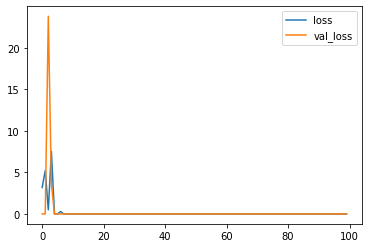

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

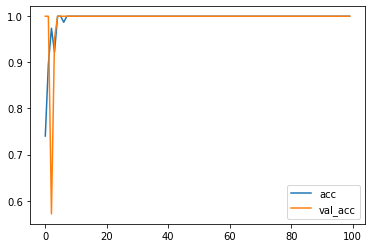

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
!unzip my_face.zip

Archive:  my_face.zip
  inflating: IMG_0779.JPG            
replace __MACOSX/._IMG_0779.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._IMG_0779.JPG  


In [ ]:
!unzip nico.zip

Archive:  nico.zip
  inflating: msg1066058093-34991.jpg  
  inflating: __MACOSX/._msg1066058093-34991.jpg  


In [ ]:
from PIL import Image
import IPython

my_face = Image.open('IMG_0779.JPG')
my_face = my_face.crop((0,0,512,512))

my_face = np.asarray(my_face)

my_face = my_face.reshape((1,512,512,3))

print(type(my_face), my_face.shape)
#my_face = preprocess_input(my_face)

features = vgg_model.predict(my_face)
result = logistic_regression_model.predict(features)

#print(result)
print(f"result: {result[0][0]:.4f}")
IPython.display.Image('IMG_0779.JPG')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(logistic_regression_model) 
tflite_model = converter.convert()

with open("logistic.tflite", "wb") as f:
  f.write(tflite_model)

ValueError: ignored